In [1]:
# imports:
import numpy as np
import matplotlib.pyplot as plt
import re
import geopandas as gpd
import os
from IPython.display import Image
from IPython.core.display import HTML 
import hvplot.xarray
import pandas as pd
import rioxarray

In [2]:
%matplotlib inline
# N.B.  This notebook is a lot more interesting if initialized with 
#%matplotlib widget

# ICESat-2

ICESat-2 is a laser altimeter designed to precisely measure the height of snow and ice surfaces using green lasers with small footprints.  Although ICESat-2 doesn't measure surface heights with the same spatial density as airborne laser altimeters, its global spatial coverage makes it a tempting source of free data about snow surfaces.  In this tutorial we will:

1. Give a brief overview of ICESat-2

2. Show how to find ICESat-2 granues using the IcePyx metadata search tool

3. Download some ATL03 photon data from the openAltimetry web service

4. Request custom processed height estimates from the SlideRule project.

## Measurements and coverage

ICESat-2 measures surface heights with six laser beams, grouped into three pairs separated by 3 km, with a 90-m separation between the beams in each pair.

Here's a sketch of how this looks (image credit: NSIDC)


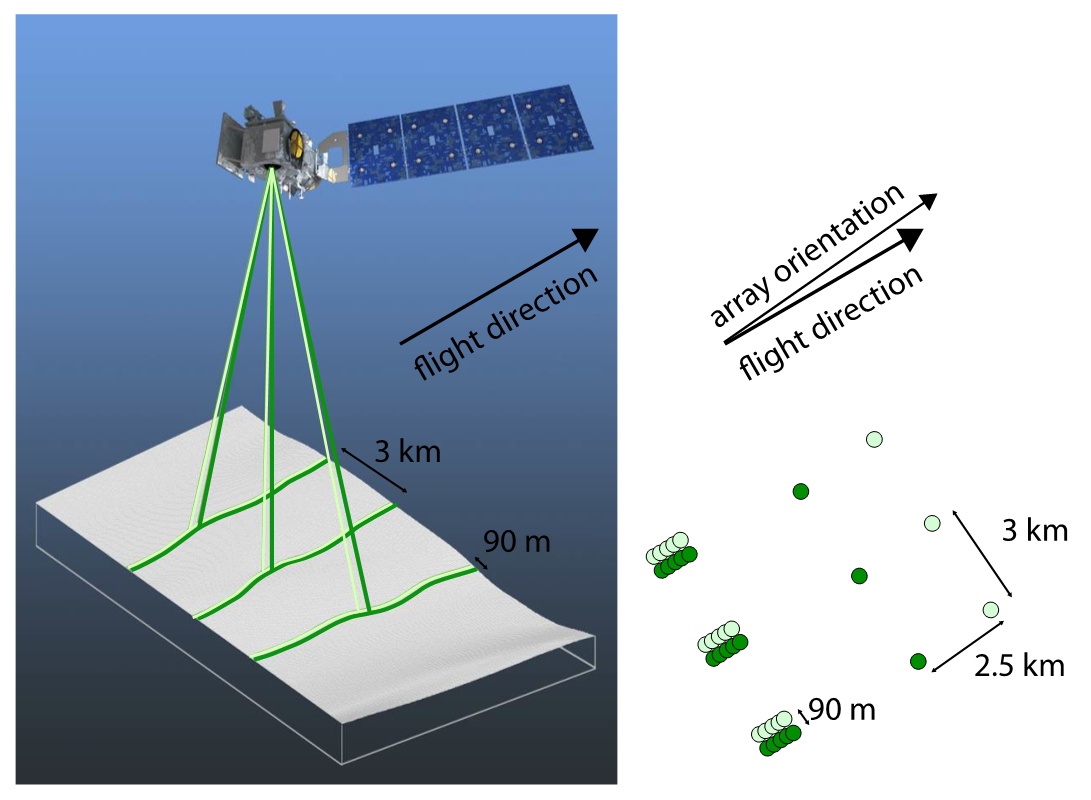

In [3]:
Image('https://nsidc.org/sites/nsidc.org/files/images/atlas-beam-pattern.png', width=500)

ICESat-2 flies a repeat orbit with 1387 ground tracks every 91 days, but over Grand Mesa, the collection strategy (up until now) has designed to optimize spatial coverage, so the measurements are shifted to the left and right of the repeat tracks to help densify the dataset.  We should expect to see tracks running (approximately) north-south over the Mesa, in tripplets of pairs that are scattered from east to west.   Because clouds often block the laser, not every track will return usable data.


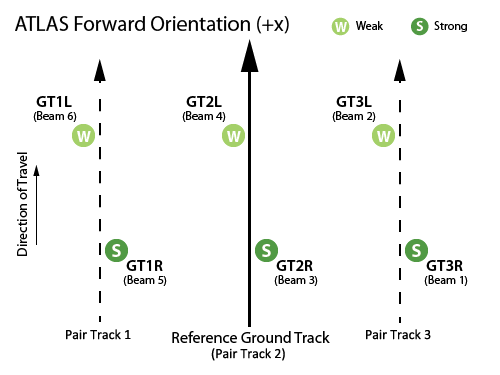

In [4]:
Image('https://nsidc.org/sites/nsidc.org/files/images/icesat-2-spots-beams-fwd-rev.png', width=500)

We describe ICESat-2's beam layout on the ground based on pairs (numbered 1, 2, and 3, from left to right) and the location of each beam in each pair (L, R).  Thus GT2L is the left beam in the center pair.  In each pair, one beam is always stronger than the other (to help penetrate thin clouds), but since the spacecraft sometimes reverses its orientation to keep the solar panels illuminated, the strong beam can be either left or right, depending on the phase of the mission.


## Basemap (Sentinel)

To get a sense of where the data are, we're going to use an Sentinel SAR image of Grand Mesa.  I've stolen this snippet of code from the SAR tutorial:

In [5]:
# GDAL environment variables to efficiently read remote data
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 

# SAR Data are stored in a public S3 Bucket
url = 's3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/12/S/YJ/2016/S1B_20161121_12SYJ_ASC/Gamma0_VV.tif'

# These Cloud-Optimized-Geotiff (COG) files have 'overviews', low-resolution copies for quick visualization
XR=[725000.0, 767000.0]
YR=[4.30e6, 4.34e6]
# open the dataset
da = rioxarray.open_rasterio(url, overview_level=1).squeeze('band')#.clip_box([712410.0, 4295090.0, 797010.0, 4344370.0])
da=da.where((da.x>XR[0]) & (da.x < XR[1]), drop=True)
da=da.where((da.y>YR[0]) & (da.y < YR[1]), drop=True)
dx=da.x[1]-da.x[0]
SAR_extent=[da.x[0]-dx/2, da.x[-1]+dx/2, np.min(da.y)-dx/2, np.max(da.y)+dx/2]

# Prepare coordinate transformations into the basemap coordinate system
from pyproj import Transformer, CRS
crs=CRS.from_wkt(da['spatial_ref'].spatial_ref.crs_wkt)
to_image_crs=Transformer.from_crs(crs.geodetic_crs, crs)
to_geo_crs=Transformer.from_crs(crs, crs.geodetic_crs)

corners_lon, corners_lat=to_geo_crs.transform(np.array(XR)[[0, 1, 1, 0, 0]], np.array(YR)[[0, 0, 1, 1, 0]])
lonlims=[np.min(corners_lat), np.max(corners_lat)]
latlims=[np.min(corners_lon), np.max(corners_lon)]


## Searching for ICESat-2 data using IcePyx

The IcePyx library has functions for searching for ICEsat-2 data, as well as subsetting it and retrieving it from NSIDC.  We're going to use the search functions today, because we don't need to retrieve the complete ICESat-2 products.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
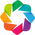

In [6]:
import requests
import icepyx as ipx

region_a = ipx.Query('ATL03', [lonlims[0], latlims[0], lonlims[1], latlims[1]], ['2018-12-01','2021-06-01'], \
                          start_time='00:00:00', end_time='23:59:59')

To run this next section, you'll need to setup your netrc file to connect to nasa earthdata.  During the hackweek we will use machine credentials, but afterwards, you may need to use your own credentials.  The login procedure is in the next cell, commented out.

In [7]:
# earthdata_uid = 'millie.spencer'
# email = 'millie.spencer@colorado.edu'
# region_a.earthdata_login(earthdata_uid, email)

Once we're logged in, the avail_granules() fetches a list of available ATL03 granules:

In [8]:
region_a.avail_granules()

{'Number of available granules': 54,
 'Average size of granules (MB)': 2150.0428941514756,
 'Total size of all granules (MB)': 116102.31628417969}

The filename for each granule (which contains lots of handy information) is in the 'producer_granule_id' field: 

In [9]:
region_a.granules.avail[0]['producer_granule_id']

'ATL03_20181213075606_11560106_006_02.h5'

The filename contains ATL03_YYYYMMDDHHMMSS_TTTTCCRR_rrr_vv.h5 where:

 * YYYMMDDHHMMSS gives the date (to the second) of the start of the granule
 * TTTT gives the ground-track number
 * CC gives the cycle number 
 * RR gives the region (what part of the orbit this is) 
 * rrr_vv give the release and version
 
 Let's strip out the date using a regular expression, and see when ICESat-2 flew over Grand Mesa:

In [10]:
ATLAS_re=re.compile('ATL.._(?P<year>\d\d\d\d)(?P<month>\d\d)(?P<day>\d\d)\d+_(?P<track>\d\d\d\d)')

date_track=[]
for count, item in enumerate(region_a.granules.avail):
    granule_info=ATLAS_re.search(item['producer_granule_id']).groupdict()
    date_track += [ ('-'.join([granule_info[key] for key in ['year', 'month', 'day']]), granule_info['track'])]

# print the first ten dates and ground tracks, plus their indexes
[(count, dt) for count, dt in enumerate(date_track[0:10])]

[(0, ('2018-12-13', '1156')),
 (1, ('2019-01-16', '0295')),
 (2, ('2019-02-13', '0714')),
 (3, ('2019-02-14', '0737')),
 (4, ('2019-03-14', '1156')),
 (5, ('2019-03-15', '1179')),
 (6, ('2019-04-12', '0211')),
 (7, ('2019-04-17', '0295')),
 (8, ('2019-05-15', '0714')),
 (9, ('2019-05-16', '0737'))]

From this point, the very capable icepyx interface allows you to order either full data granules or subsets of granules from NSIDC.  Further details are available from https://icepyx.readthedocs.io/en/latest/, and their 'examples' pages are quite helpful.  Note that ATL03 photon data granules are somewhat cumbersome, so downloading them without subsetting will be time consuming, and requesting subsetting from NSIDC may take a while.  

## Ordering photon data from openAltimetry
For ordering small numbers of points (up to one degree worth of data), the openAltimetry service provides very quick and efficient access to a simplified version of the ATL03 data.  Their API (https://openaltimetry.org/data/swagger-ui/) allows us to build web queries for the data.  We'll use that for a quick look at the data over Grand Mesa, initially reading just one central beam pair:

In [11]:
def get_OA(date_track, lonlims, latlims, beamnames=["gt1l","gt1r","gt2l","gt2r","gt3l","gt3r"]):
    '''
    retrieve ICESat2 ATL03 data from openAltimetry
    
    Inputs:
        date_track: a list of tuples.  Each contains a date string "YYYY-MM-DD" and track number (4-character string)
        lonlims: longitude limits for the search
        latlims: latitude limits for the search
        beamnames: list of strings for the beams
    outputs:
        a dict containing ATL03 data by beam name
    
    Due credit:
        Much of this code was borrowed Philipp Arndt's Pond Picker repo: https://github.com/fliphilipp/pondpicking
    '''
    
    
    IS2_data={}
    for this_dt in date_track:
        this_IS2_data={}
        for beamname in beamnames:
            oa_url = 'https://openaltimetry.org/data/api/icesat2/atl03?minx={minx}&miny={miny}&maxx={maxx}&maxy={maxy}&trackId={trackid}&beamName={beamname}&outputFormat=json&date={date}&client=jupyter'
            oa_url = oa_url.format(minx=lonlims[0],miny=latlims[0],maxx=lonlims[1], maxy=latlims[1], 
                                   trackid=this_dt[1], beamname=beamname, date=this_dt[0], sampling='true')
            #.conf_ph = ['Noise','Buffer', 'Low', 'Medium', 'High']
            if True:
                r = requests.get(oa_url)
                data = r.json()
                D={}
                D['lat_ph'] = []
                D['lon_ph'] = []
                D['h_ph'] = []
                D['conf_ph']=[]
                conf_ph = {'Noise':0, 'Buffer':1, 'Low':2, 'Medium':3, 'High':4}
                for beam in data:
                    for photons in beam['series']:
                        for conf, conf_num in conf_ph.items():         
                            if conf in photons['name']:
                                for p in photons['data']:
                                    
                                    D['lat_ph'].append(p[0])
                                    D['lon_ph'].append(p[1])
                                    D['h_ph'].append(p[2])
                                    D['conf_ph'].append(conf_num)
                    D['x_ph'], D['y_ph']=to_image_crs.transform(D['lat_ph'], D['lon_ph'])
                for key in D:
                    D[key]=np.array(D[key])
                if len(D['lat_ph']) > 0:
                    this_IS2_data[beamname]=D
            #except Exception as e:
            #    print(e)
            #    pass
        if len(this_IS2_data.keys()) > 0:
            IS2_data[this_dt] = this_IS2_data
    return IS2_data

In [12]:
#submitting all of these requests should take about 1 minute
IS2_data=get_OA(date_track, lonlims, latlims, ['gt2l'])

ConnectTimeout: HTTPSConnectionPool(host='openaltimetry.org', port=443): Max retries exceeded with url: /data/api/icesat2/atl03?minx=-108.408343209786&miny=38.80833384091803&maxx=-107.90953763121124&maxy=39.18014315670584&trackId=1156&beamName=gt2l&outputFormat=json&date=2018-12-13&client=jupyter (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7fb9cc45aef0>, 'Connection to openaltimetry.org timed out. (connect timeout=None)'))

In [ ]:
plt.figure()
plt.imshow(np.array(da)[::-1,:], origin='lower', extent=SAR_extent, cmap='gray', clim=[0, 0.5])#plt.figure();

for dt, day_data in IS2_data.items():
    for beam, D in day_data.items():
        plt.plot(D['x_ph'][::10], D['y_ph'][::10], '.', markersize=3, label=str(dt))


What we see in this plot is Grand Mesa, with lines showing data from the center beams of several tracks passing across it.  A few of these tracks have been repeated, but most are offset from the others.  Looking at these, it should be clear that the quality of the data is not consistent from track to track.  Some are nearly continuous, others have gaps, and other still have no data at all and are not plotted here.  Remember, though, that what we've plotted here are just the center beams.  There are a total of two more beam pairs, and a total of five more beams!

To get an idea of what the data look like, we'll pick one of the tracks and plot its elevation profile.  In interactive mode (%matplotlib widget) it's possible to zoom in on the plot, query the x and y limits, and use these to identify the data for the track that intersects an area of interest.  I've done this to pick two good-looking tracks, but you can uncomment the first two lines here and zoom in yourself to look at other tracks:

In [ ]:
XR=plt.gca().get_xlim()
YR=plt.gca().get_ylim()
print(XR)
print(YR)

In [ ]:
#XR=plt.gca().get_xlim()
#YR=plt.gca().get_ylim()
XR=(740773.7483556366, 741177.9430390946)
YR=(4325197.508090873, 4325728.013612912)

dts_in_axes=[]
for dt, day_data in IS2_data.items():
    for beam, D in day_data.items():
        if np.any(
            (D['x_ph'] > XR[0]) & (D['x_ph'] < XR[1]) &
            (D['y_ph'] > np.min(YR)) & (D['y_ph'] < np.max(YR))):
            dts_in_axes += [dt]
dts_in_axes

Based on the axis limits I filled in, Track 295 has two repeats over the mesa that nearly coincide.

Now we can get the full (six-beam) dataset for one of these repeats and plot it:

In [ ]:
full_track_data=get_OA([dts_in_axes[0]], lonlims, latlims)

In [ ]:

fig=plt.figure(); 
hax=fig.subplots(1, 2)
plt.sca(hax[0])
plt.imshow(np.array(da)[::-1,:], origin='lower', extent=SAR_extent, cmap='gray', clim=[0, 0.5])#plt.figure();

for dt, day_data in full_track_data.items():
    for beam, D in day_data.items():
        plt.plot(D['x_ph'], D['y_ph'],'.', markersize=1)
plt.title(dts_in_axes[0])

plt.sca(hax[1])
D=day_data['gt2l']
colors_key={((0,1)):'k', (2,3,4):'r'}
for confs, color in colors_key.items():
    for conf in confs:
        these=np.flatnonzero(D['conf_ph']==conf)
        plt.plot(D['y_ph'][these], D['h_ph'][these],'.', color=color, markersize=1)#label=','.join(list(confs)))
plt.ylabel('WGS-84 height, m');
plt.xlabel('UTM-12 northing, m');
plt.title('gt2l');
plt.tight_layout()

On the left we see a plot of all six beams crossing (or almost crossing) Grand Mesa, in April of 2020.  If you zoom in on the plot, you can distinguish the beam pairs into separate beams.  On the right, we see one of the central beams crossing the mesa from south to north.  There is a broad band of noise photons that were close enough to the ground to be telemetered by the satellite, and a much narrower band (in red) of photons identified by the processing software as likely coming from the ground.

These data give a maximum of detail about what the surface looks like to ICESat-2.  to reduce this to elevation data, telling the surface height at specific locations, there are a few options:
    
    1. Download higher-level products (i.e. ATL06, ATL08) from NSIDC
    2. Calculate statistics of the photons (i.e. a running mean of the flagged photon heights
    3. Ask the SlideRule service to calculate along-track averages of the photon heights.

We're going to try (3).

## Ordering surface-height segments from SlideRule

SildeRule is a new and exciting (to me) system that does real-time processing of ICESat-2 data _in the cloud_ while also offering efficient web-based delivery of data products.  It's new, and it's not available for all locations, but Grand Mesa is one of the test sites, so we should be able to get access to the full set of ATL03 data there.
[MORE WORK TO GO HERE]

You'll need to install the sliderule-python package, available from https://github.com/ICESat2-SlideRule/sliderule-python
This package has been installed on the hub, but if you need it, these commands will install it:

In [ ]:
#! [ -d sliderule-python ] || git clone https://github.com/ICESat2-SlideRule/sliderule-python.git 
#! cd sliderule-python; python setup.py develop

We will submit a query to sliderule to process all of the data that CMR finds for our region, fitting 20-meter line-segments to all of the photons with medium-or-better signal confidence

In [ ]:
import pandas as pd
from sliderule import icesat2

# initialize
icesat2.init("icesat2sliderule.org", verbose=False)

# region of interest polygon
region = [ {"lon":lon_i, "lat":lat_i} for lon_i, lat_i in 
          zip(np.array(lonlims)[[0, -1, -1, 0, 0]],  np.array(latlims)[[0, 0, -1, -1, 0]])]

# request parameters
params = {
    "poly": region,  # request the polygon defined by our lat-lon bounds
    "srt": icesat2.SRT_LAND, # request classification based on the land algorithm
    "cnf": icesat2.CNF_SURFACE_MEDIUM, # use all photons of low confidence or better
    "len": 20.0,  # fit data in overlapping 40-meter segments
    "res": 10.0,  # report one height every 20 m
    "ats":5., #report a segment only if it contains at least 2 photons separated by 5 m
    "maxi": 6,  # allow up to six iterations in fitting each segment to the data
}

# make request
rsps = icesat2.atl06p(params, "atlas-s3")

# save the result in a dataframe
df = pd.DataFrame(rsps)

# calculate the polar-stereographic coordinates:
df['x'], df['y']=to_image_crs.transform(df['lat'], df['lon'])


SlideRule complains when it tries to calculate heights within our ROI for ground tracks that don't intersect the ROI.  This happens quite a bit because the CMR service that IcePyx and SlideRule use to search for the data uses a generous buffer on each ICESat-2 track.  It shouldn't bother us.  In fact, we have quite a few tracks for our region.

Let's find all the segments from rgt 295, cycle 7 and map their heights:

In [ ]:
plt.figure(); 
plt.imshow(np.array(da)[::-1,:], origin='lower', extent=SAR_extent, cmap='gray', clim=[0, 0.5])#plt.figure();
ii=(df['rgt']==295) & (df['cycle']==7)
plt.scatter(df['x'][ii], df['y'][ii],4, c=df['h_mean'][ii], cmap='gist_earth')
plt.colorbar()

As we saw a few cells up, for track 295 cycles 7 and 8 are nearly exact repeats.  Cycle 7 was April 2020, cycle 8 was July 2020.  Could it be that we can measure snow depth in April by comparing the two?  Let's plot spot 3 for both!

In [ ]:
plt.figure();
ii=(df['rgt']==295) & (df['cycle']==7) & (df['spot']==3)
plt.plot(df['y'][ii], df['h_mean'][ii],'.', label='April')
ii=(df['rgt']==295) & (df['cycle']==8) & (df['spot']==3)
plt.plot(df['y'][ii], df['h_mean'][ii],'.', label='July')

plt.legend()

plt.xlabel('polar stereographic northing, m')
plt.ylabel('height, m')

To try to get at snow depth, we can look for bare-earth DTMs here:
    'https://prd-tnm.s3.amazonaws.com/LidarExplorer/index.html#'
I've picked one of the 1-meter DTMs that covers part of track 295.  We'll read it directly from s3 with the rasterio/xarray package, and downsample it to 3m (to save time later).

In [ ]:
import rioxarray as rxr
from rasterio.enums import Resampling

url='https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/Projects/CO_MesaCo_QL2_UTM12_2016/TIFF/USGS_one_meter_x74y433_CO_MesaCo_QL2_UTM12_2016.tif'

lidar_ds=rxr.open_rasterio(url)
#resample the DTM to ~3m:
scale_factor = 1/3
new_width = int(lidar_ds.rio.width * scale_factor)
new_height = int(lidar_ds.rio.height * scale_factor)

#reproject the horizontal CRS to match ICESat-2
UTM_wgs84_crs=CRS.from_epsg(32612)
lidar_3m = lidar_ds.rio.reproject(
    UTM_wgs84_crs,
    shape=(new_height, new_width),
    resampling=Resampling.bilinear,
)


In [ ]:
plt.figure(); 
lidar_3m.sel(band=1).plot.imshow()

To compare the DTM directly with the ICESat-2 data, we'll need to sample it at the ICESat-2 points.  There are probably ways to do this directly in xarray, but I'm not an expert.  Here we'll use a scipy interpolator:

In [ ]:
from scipy.interpolate import RectBivariateSpline
interpolator = RectBivariateSpline(np.array(lidar_3m.y)[::-1], np.array(lidar_3m.x), 
                                   np.array(lidar_3m.sel(band=1))[::-1,:], kx=1, ky=1)


In [ ]:
x0=np.array(lidar_3m.x)
y0=np.array(lidar_3m.y)

ii=(df['rgt']==295) & (df['cycle']==7) & (df['spot']==3)
ii &= (df['x'] > np.min(x0)) & (df['x'] < np.max(x0))
ii &= (df['y'] > np.min(y0)) & (df['y'] < np.max(y0))

zi=interpolator.ev(df['y'][ii], df['x'][ii])

In [ ]:
fig=plt.figure(figsize=[8, 5]); 
hax=fig.subplots(1,2)
plt.sca(hax[0])
lidar_3m.sel(band=1).plot.imshow()
plt.plot(df['x'][ii], df['y'][ii],'.')
plt.axis('equal')

plt.sca(hax[1])
plt.plot(df['y'][ii], df['h_mean'][ii],'.', label='April')
plt.plot(df['y'][ii], zi,'.', label='DTM')
plt.legend()
plt.tight_layout()

The DTM is below the April ICESat-2 heights.  That's probably not right, and it's because we don't have the vertical datums correct here (ICESat-2 WGS84, the DEM is NAD83).  That's OK!  Since we have multiple passes over the same DEM, we can use the DEM to correct for spatial offsets between the measurements.  Let's use the DEM to correct for differences between the July and April data:

In [ ]:
plt.figure()

ii=(df['rgt']==295) & (df['cycle']==7) & (df['spot']==3)
ii &= (df['x'] > np.min(x0)) & (df['x'] < np.max(x0))
ii &= (df['y'] > np.min(y0)) & (df['y'] < np.max(y0))
zi=interpolator.ev(df['y'][ii], df['x'][ii])

plt.plot(df['y'][ii], df['h_mean'][ii]-zi,'.', label='April')

ii=(df['rgt']==295) & (df['cycle']==8) & (df['spot']==3)
ii &= (df['x'] > np.min(x0)) & (df['x'] < np.max(x0))
ii &= (df['y'] > np.min(y0)) & (df['y'] < np.max(y0))
zi=interpolator.ev(df['y'][ii], df['x'][ii])


plt.plot(df['y'][ii], df['h_mean'][ii]-zi,'.', label='July')
plt.gca().set_ylim([-20, -10])

plt.legend()


This looks good, if a little noisy.  We could get a better comparison by (1) using multiple ICESat-2 tracks to extract a mean snow-off difference between the DTM and ICESat-2, or (2). finding adjacent pairs of measurements  between the two tracks, and comparing their heights directly.  These are both good goals for projects!


## Further reading:


There are lots of resources available for ICESat-2 data on the web.  Two of the best are the NSIDC ICESat-2 pages:

https://nsidc.org/data/icesat-2

and NASA's ICESat-2 page:
https://icesat-2.gsfc.nasa.gov